# Exploring parameters

#### density plots, post predictive checks etc.

In [1]:
%load_ext autoreload
%autoreload 2
import os.path as op
import tempfile

import matplotlib.pyplot as plt


import hnn_core
from hnn_core import simulate_dipole, jones_2009_model
from hnn_core.viz import plot_dipole


import sys
sys.path.append('../code/')
sys.path.append('../code/utils/')
#sys.path.append('../code/sbi/')
#sys.path.append('../../results_cluster/')


import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt


import os

work_dir = '/home/ubuntu/sbi_for_eeg_data/code/'

os.chdir(work_dir)

#from utils.plot import cov, compare_vars, plot_varchanges
#from utils.plot import compare_KLs, plot_KLs
#from sbi.inference import potentials
import utils.sbi_modulated_functions

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

from sbi.analysis import conditional_pairplot, conditional_corrcoeff



# import the summary statistics that you want to investigate
from summary_features.calculate_summary_features import calculate_summary_statistics_alternative as alternative_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal as temporal_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_number as number_sumstats
from summary_features.calculate_summary_features import calculate_summary_stats_temporal


In [2]:
print(torch.__version__)

1.9.1+cu102


In [3]:
## defining neuronal network model

num_params = 6

from utils.simulation_wrapper import set_network_default, SimulationWrapper
sim_wrapper = SimulationWrapper(num_params, noise=False)


In [26]:
from utils import inference

import pickle
from data_load_writer import *
from data_load_writer import load_from_file as lf

import os

work_dir = '/home/ubuntu/'

os.chdir(work_dir)



import os

print(os.getcwd())



file = 'toy_example_maf_08_04_lesser_ratio'


print(os.getcwd())

os.chdir('results/{}'.format(file))


print(os.getcwd())
  



/home/ubuntu
/home/ubuntu
/home/ubuntu/results/toy_example_maf_08_04_lesser_ratio


In [27]:
def Gaussian(thetas, normal_noise=1):
    
    gauss_list = []
    
    for theta in thetas:
    
        mu, sigma = theta, normal_noise # mean and standard deviation

        s = np.random.normal(mu, sigma, 1)
    
        
        gauss_list.append(s[0])
        
    gauss_obs = torch.tensor(gauss_list)
    
    return gauss_obs
    



In [28]:
list_collection = torch.load('list_collection.pt')
list_collection_inc = torch.load('list_collection_inc.pt')

In [29]:
true_thetas = torch.tensor([[3.0, 6.0, 20.0, 10.0, 90.0, 55.0, 27.0, 27.0, 4.0, 70.0, 5.0, 66.0, 99.0, 40.0, 45.0]])
parameter_names = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15']

prior_max = [100.0] * 15
prior_min = [1.0] * 15

prior = utils.torchutils.BoxUniform(low=prior_min, high = prior_max)

samples_prior = prior.sample((10000,))

simulator_stats, prior = prepare_for_sbi(Gaussian, prior)

In [30]:
samples_prior_list = samples_prior.unsqueeze(0)

In [31]:
samples_prior_list[0].shape

torch.Size([10000, 15])

In [32]:
thetas = inference.run_only_sim(samples_prior_list, simulation_wrapper = simulator_stats, num_workers=1)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished


In [33]:
def KL_Gauss(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)

    var_y = Y.stddev

    mu_y = Y.mean
    
    
    return torch.mean(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)), var_x, mu_x


def calc_KL_1d(X, Y):
    
    sample_x = X.sample((1000,))
    mu_x = torch.mean(sample_x, dim=0)
    var_x = torch.std(sample_x, dim=0)
    
    print(var_x)
    print(mu_x)


    var_y = Y.stddev

    mu_y = Y.mean
    
    print(mu_y)
    print(var_y)
    
    print(np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2))
    
    return np.log(var_y/var_x) + (var_x**2 + (mu_x - mu_y)**2)/(2*var_y**2) -(1/2)


# calculate the jensen-shanon divergence
def js_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * kl_divergence(p, m) + 0.5 * kl_divergence(q, m)

In [34]:

analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_snpe_list = []

variance_list_snpe = []

mean_list_snpe = []


## for round
for posterior_snpe_list in list_collection:
    
    KL_snpe = []
    KL_snpe_1d = []
    
    
    ## for number of simulations
    for posterior_snpe in posterior_snpe_list:


        #KL = KLdivergence(posterior_snpe, sample_y)
        KL, var_x, mu_x = KL_Gauss(posterior_snpe, analytic)
        
        variance_list_snpe.append(var_x)
        
        mean_list_snpe.append(mu_x)


        KL_1d = calc_KL_1d(posterior_snpe, analytic)

        KL_snpe_1d.append(KL_1d)

        #KL_snpe_sum.append(sum_KL)

        KL_snpe.append(KL)
        
    overall_snpe_list.append(KL_snpe)


    
    

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([5.0052, 5.3878, 4.6121, 4.0123, 4.9192, 2.2973, 3.0643, 3.2328, 3.9826,
        3.3701, 4.5230, 3.0755, 5.2773, 2.6041, 2.1775])
tensor([ 8.6490, 10.4139, 21.0003,  9.4431, 82.2151, 52.4170, 34.0788, 26.8598,
        10.4750, 66.4835,  8.6875, 64.8512, 89.2628, 41.8978, 46.5049])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[26.3710, 22.0712,  9.1074,  6.3148, 40.3082,  4.6430, 28.1302,  3.5619,
         27.0115, 10.1468, 15.0182,  3.7657, 59.1683,  3.7343,  2.2249]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([2.8597, 5.3218, 5.5840, 5.4296, 4.6684, 2.8372, 3.9554, 3.2264, 4.0327,
        3.2264, 5.5209, 3.3890, 2.8953, 3.1122, 2.4886])
tensor([ 4.6527, 11.8572, 24.1122, 13.8919, 92.1315, 55.4455, 22.6598, 27.6212,
         8.4611, 70.1690, 12.3387, 62.9723, 96.0146, 42.2285, 48.4439])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 3.9039, 29.1427, 21.8256, 20.1220, 11.1275,  2.5812, 15.3661,  3.7264,
         16.1879,  3.5477, 39.9596,  8.6055,  7.0846,  5.6905,  7.6151]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([2.4802, 3.7287, 3.2861, 4.2968, 3.5886, 2.0410, 2.8914, 3.1139, 3.8793,
        2.2303, 4.3501, 2.8681, 3.5257, 1.7887, 2.5020])
tensor([ 3.9095,  7.2795, 22.6315, 11.8387, 94.0944, 56.8993, 27.5352, 27.8070,
        12.1807, 66.1515, 10.4362, 63.9445, 95.0845, 38.2387, 45.5661])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 2.0809,  5.9540,  7.1717,  8.9636, 13.0431,  2.6731,  2.7615,  3.5380,
         39.1308,  8.5906, 22.2677,  4.6718, 12.1207,  2.0695,  1.8730]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([3.5868, 3.3036, 2.6442, 5.2987, 2.8190, 1.6843, 3.7826, 3.1229, 3.5567,
        2.4702, 3.9212, 2.5011, 3.4034, 2.6059, 2.9405])
tensor([ 7.0546,  5.6077, 21.6002, 18.3668, 88.0503, 55.8696, 24.1828, 32.6074,
         8.4382, 67.1821,  9.0244, 64.7060, 95.2903, 38.5164, 46.7261])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[12.8751,  3.8387,  3.3040, 46.8723,  4.3376,  0.7752,  9.2919, 18.9586,
         14.4051,  5.6168, 13.9195,  2.5482, 10.9478,  3.0382,  4.2343]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([4.4793, 4.8623, 3.4467, 3.8567, 3.8300, 1.9293, 3.1802, 2.8902, 4.7816,
        3.2218, 5.7740, 3.0521, 5.1832, 2.5196, 2.5496])
tensor([ 8.0315, 11.6874, 20.2573, 17.1612, 89.5685, 55.4891, 28.7070, 26.3372,
        10.7931, 62.2082, 16.1786, 67.0404, 93.1195, 43.0275, 45.9648])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[20.6905, 25.9130,  4.2357, 31.2285,  5.5846,  0.8236,  4.8569,  2.8348,
         32.4407, 33.8759, 76.8974,  3.5831, 28.5776,  6.3330,  2.2797]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([4.3029, 3.9389, 2.8148, 4.1539, 3.1945, 3.1226, 4.1319, 2.8671, 4.1684,
        3.9777, 4.6842, 2.9797, 4.5512, 2.3408, 2.1597])
tensor([ 7.3276,  7.3486, 22.2022, 10.8882, 89.0010, 52.5572, 33.2048, 30.8981,
         9.3555, 65.8873, 12.3200, 63.0858, 92.2833, 41.8941, 44.6737])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[16.6623,  6.7959,  4.8515,  7.0977,  3.9400,  6.2203, 25.8672, 10.1546,
         21.1014, 14.4874, 35.7176,  7.0936, 30.8980,  3.1831,  1.1154]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([4.1742, 4.2678, 3.6520, 5.0413, 5.4643, 2.7619, 4.5338, 3.1480, 5.2222,
        2.3009, 5.3098, 3.2636, 3.3309, 3.0163, 2.6372])
tensor([ 7.0572,  7.7226, 21.3012,  9.6074, 86.7005, 55.2397, 29.3720, 30.3851,
        10.5771, 67.8753,  9.2966, 60.2296, 95.4062, 38.5189, 46.2528])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[15.0132,  8.6396,  5.7198, 10.6666, 18.1741,  2.3270, 11.0791,  9.0374,
         33.1122,  3.5710, 21.1581, 20.2914, 10.3019,  4.0419,  2.7924]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 904 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 396 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


tensor([3.6649, 5.8475, 3.9929, 4.7433, 5.1628, 2.1785, 3.9148, 3.3838, 3.6039,
        3.4572, 4.8985, 2.9318, 3.1012, 2.8619, 3.1291])
tensor([ 5.8222, 13.4722, 26.4011, 11.9638, 91.7899, 58.7480, 26.8465, 23.6322,
         6.1694, 76.3360,  8.6007, 61.1729, 95.9388, 42.0260, 44.4007])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 8.8992, 42.7477, 26.5742, 11.1209, 12.7875,  8.1181,  5.8100,  9.6773,
          7.0649, 24.3078, 16.3913, 14.3725,  7.8624,  4.5961,  3.4346]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([3.1338, 4.1292, 3.4119, 2.9949, 4.4737, 2.0436, 3.2658, 2.2322, 4.9168,
        2.4445, 3.8080, 2.7398, 5.5360, 1.9873, 2.0323])
tensor([ 5.7087, 10.2310, 21.9761, 12.8987, 85.1334, 56.8657, 31.1774, 30.1910,
        10.6906, 66.5863,  7.0419, 65.0694, 89.1538, 39.6794, 47.0626])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 6.9369, 15.5578,  6.0457,  7.0889, 19.8507,  2.6140, 12.3745,  6.2796,
         32.3770,  7.4208,  7.4982,  2.6784, 61.5856,  0.8393,  2.9832]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([3.5083, 3.3638, 3.2558, 3.3627, 4.1492, 2.1364, 2.8900, 2.7693, 3.9524,
        3.0013, 7.2788, 4.0907, 3.6456, 2.4811, 1.9150])
tensor([ 9.1407,  7.0696, 21.6730, 11.9383, 87.8225, 54.2458, 25.4552, 29.0992,
         8.5803, 67.6099, 14.7887, 63.1547, 95.0790, 38.7394, 46.4265])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[23.2530,  4.5164,  5.0192,  5.8196,  9.0557,  1.3074,  3.8080,  4.5192,
         16.4260,  5.7612, 71.9141, 10.5060, 12.5391,  2.4637,  1.7014]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([3.6309, 3.7487, 3.9116, 5.1416, 3.7296, 2.7785, 3.5816, 3.4182, 4.0746,
        2.3845, 3.8076, 2.6633, 3.7510, 2.4741, 2.2659])
tensor([ 9.0809,  7.8278, 20.9229, 11.6188, 90.4591, 58.1332, 29.1895, 26.0161,
         7.8463, 69.3232,  6.3224, 61.8246, 94.5159, 37.0046, 43.8296])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[23.2911,  6.8755,  6.2124, 12.3910,  5.2441,  7.2466,  7.0351,  4.5971,
         13.7932,  1.7029,  6.2863, 10.7839, 15.2665,  6.1410,  1.9341]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 1000 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 999 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


tensor([1.2790, 5.1593, 1.7369, 2.5827, 2.9758, 2.0675, 1.9363, 1.5997, 2.8807,
        2.1223, 2.0976, 1.6069, 0.9146, 1.5824, 1.5719])
tensor([ 2.4911, 11.1539, 23.6073,  5.7544, 89.3695, 57.8018, 30.2785, 29.2975,
         5.7753, 66.4348,  5.5229, 64.1911, 99.0394, 40.2232, 46.4200])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[2.0136e-01, 2.4450e+01, 6.9626e+00, 1.0899e+01, 3.0360e+00, 4.8359e+00,
         6.0881e+00, 2.9490e+00, 4.1672e+00, 7.3548e+00, 1.0959e+00, 1.9528e+00,
         8.2962e-03, 3.1794e-01, 1.2914e+00]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([3.9059, 4.3512, 4.0318, 3.5137, 3.7385, 2.8645, 3.8443, 2.9336, 5.0458,
        3.3984, 4.2314, 2.5964, 2.8579, 2.6632, 2.8844])
tensor([ 6.7179, 12.4371, 25.4154,  8.3625, 88.4886, 53.6374, 23.4351, 28.2311,
        10.0016, 69.6760,  7.6560, 63.3555, 96.3856, 42.3676, 43.5934])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[12.6767, 28.2140, 20.8965,  5.7572,  6.3115,  3.4787, 11.8972,  3.4846,
         28.6209,  4.1038, 10.5371,  5.4132,  5.9513,  4.8696,  3.5899]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([3.8140, 5.9654, 4.2126, 4.2058, 4.4554, 2.3785, 2.7536, 3.1505, 3.6012,
        2.4232, 4.9126, 3.4311, 5.9410, 2.5195, 2.8634])
tensor([ 7.5029, 14.5072, 24.1854, 10.5302, 88.5598, 55.4220, 27.8618, 32.0941,
         7.0305, 66.7874,  9.7065, 62.5234, 89.6679, 41.6580, 49.2756])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[15.5728, 51.6933, 15.6937,  7.0486,  8.9682,  1.5512,  2.6496, 16.2903,
          9.2948,  6.7113, 21.0508, 10.1966, 58.9098,  3.1242, 11.6881]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 995 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 990 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


tensor([3.0374, 5.6740, 4.4099, 2.3368, 3.7264, 2.1660, 3.5793, 3.1281, 2.6364,
        2.7130, 4.0687, 3.0406, 4.2868, 3.2225, 2.5575])
tensor([ 4.9414, 11.2618, 20.4682,  4.0404, 91.7917, 57.3965, 30.0317, 24.5559,
         4.3743, 67.0556,  7.2502, 65.1692, 94.7501, 40.1819, 47.0439])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 4.8863, 27.7046,  7.8492, 19.1399,  6.7325,  3.9444,  9.2263,  6.2389,
          2.0760,  6.5170,  8.9054,  3.3557, 16.2634,  3.5386,  3.9202]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([4.3077, 3.3787, 2.5054, 3.2403, 3.8266, 1.8612, 3.1127, 2.9321, 3.8693,
        2.8156, 3.3129, 2.7962, 3.7025, 2.1357, 1.6791])
tensor([ 9.0214,  6.0001, 17.8279,  8.8052, 85.6584, 55.1647, 28.4963, 29.0256,
         8.1903, 67.2206,  6.2869, 61.2977, 94.4177, 39.2987, 47.2369])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[25.4464,  3.9902,  4.0791,  4.2880, 14.9044,  0.6244,  4.3285,  4.7745,
         14.4120,  6.2913,  4.6180, 13.4372, 15.5439,  1.2677,  2.8934]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([3.8756, 3.7086, 2.9565, 3.3988, 4.2583, 1.9401, 3.3797, 2.7212, 3.4593,
        3.4671, 3.3958, 2.0289, 5.2101, 2.2219, 1.5860])
tensor([ 8.2834,  7.6616, 21.8163,  8.8751, 87.6477, 53.3898, 28.5939, 27.7698,
         6.0866, 65.5726,  7.0816, 62.8727, 92.8127, 41.0964, 44.7285])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[19.6122,  6.4467,  4.4359,  4.6851,  9.8846,  2.0157,  5.2637,  2.4977,
          6.4194, 14.0678,  6.2095,  5.7406, 30.5632,  1.7711,  0.3334]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 924 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 920 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


tensor([2.8488, 2.7059, 2.6770, 2.4018, 2.5117, 1.0209, 1.8077, 1.9217, 2.9271,
        2.0880, 2.5017, 1.4260, 1.2290, 1.3924, 2.2924])
tensor([ 5.7485,  8.7632, 24.1680, 14.2072, 96.6968, 54.7873, 25.4729, 27.0053,
         6.6107, 66.7963,  4.6469, 64.0416, 98.6590, 36.9649, 51.7817])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[6.2880e+00, 5.9833e+00, 1.0784e+01, 1.0359e+01, 2.4157e+01, 2.3060e-02,
         1.7077e+00, 6.9325e-01, 6.1179e+00, 6.0755e+00, 1.7747e+00, 2.0796e+00,
         1.0713e-01, 4.7443e+00, 2.4294e+01]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([3.5956, 4.2323, 3.6383, 4.6035, 4.9633, 2.0671, 3.3813, 4.7629, 4.4333,
        3.6069, 4.3549, 3.1834, 4.0456, 2.8060, 2.3746])
tensor([ 8.0197,  8.3917, 22.7379, 11.3051, 81.3139, 55.8138, 28.8273, 26.7663,
         9.8138, 63.9101,  7.9217, 64.5993, 94.2875, 41.0084, 46.1802])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[17.2831,  9.8736,  8.5750,  9.4210, 47.9389,  1.2415,  5.6678,  9.3092,
         24.7379, 23.2653, 11.7794,  4.3900, 17.3896,  2.9135,  2.1509]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([4.5702, 4.2131, 3.9048, 5.0969, 3.8470, 2.7822, 2.8224, 3.2223, 4.0188,
        3.2844, 3.2632, 2.9894, 3.4714, 2.3822, 3.7635])
tensor([11.0984,  8.2422, 23.4792, 10.0682, 89.8931, 56.9861, 24.3891, 29.5303,
         6.9463, 66.3402,  6.0176, 65.6056, 95.5846, 40.3532, 43.6563])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[41.2157,  9.4504, 11.8140, 10.8627,  5.5582,  4.3194,  5.8538,  6.7228,
         10.5248, 10.4014,  4.1594,  2.9509, 10.1131,  1.5317,  6.1594]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([3.0922, 3.5273, 3.2141, 4.1589, 4.1424, 2.4785, 2.7430, 3.3584, 4.0413,
        3.2746, 2.6949, 2.8560, 3.0694, 2.1905, 2.3042])
tensor([ 5.4771,  7.5233, 22.1804,  9.6342, 87.5287, 54.6684, 26.5838, 31.6442,
        10.9864, 65.2191,  4.5888, 64.7355, 95.9775, 40.1158, 44.7729])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 6.2201,  5.6204,  5.8748,  6.7901,  9.7123,  1.7187,  2.3396, 14.7121,
         30.6741, 15.1039,  2.2245,  3.3285,  7.6569,  1.1217,  1.3457]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([2.5717, 3.7794, 3.4127, 3.9530, 4.1765, 1.5411, 2.6803, 2.9629, 4.1359,
        2.1815, 3.4317, 2.7584, 2.9575, 2.2462, 1.7119])
tensor([ 4.3891,  7.3512, 24.0114, 13.6423, 88.7338, 56.8258, 26.5775, 28.3125,
        10.9706, 66.0934,  6.4551, 67.2466, 95.4256, 40.1056, 46.7097])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 2.8271,  6.2253, 12.1416, 12.5716,  7.5936,  1.9218,  2.1953,  3.6647,
         30.9282,  8.7301,  5.2139,  3.0668,  9.1773,  1.2190,  1.8893]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 979 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 975 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


tensor([3.5210, 3.0285, 2.5255, 3.1359, 3.9999, 2.1786, 2.6264, 2.8428, 4.1387,
        2.7560, 4.2003, 1.9580, 2.0320, 2.5958, 1.8864])
tensor([ 7.4295,  6.5928, 21.6397, 10.0845, 87.5523, 54.8087, 26.7226, 28.0996,
         8.3932, 65.8867,  9.5492, 63.1223, 97.7215, 38.4554, 46.6003])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[14.2500,  3.1535,  3.1070,  3.2775,  9.1087,  1.1127,  2.0218,  3.1004,
         16.2943, 10.7435, 17.2336,  4.8854,  1.6728,  3.1081,  1.9250]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 910 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 905 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


tensor([1.0507, 2.5020, 2.7317, 2.5209, 3.8376, 1.5449, 1.9642, 1.6941, 2.0867,
        1.9063, 2.7371, 1.6742, 1.1364, 1.2856, 1.0888])
tensor([ 2.2054,  8.4085, 20.5022, 10.4937, 92.6832, 55.4458, 27.5598, 28.7950,
         4.7471, 68.5268,  7.2592, 66.0778, 98.6494, 38.7311, 46.5579])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[0.3182, 4.6134, 2.3522, 1.8747, 9.1184, 0.3577, 0.9107, 2.0188, 1.2206,
         1.7570, 4.7908, 0.3892, 0.0793, 0.8802, 1.2212]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 923 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 904 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


tensor([4.6482, 3.7066, 4.4282, 4.8394, 6.0726, 3.6644, 3.8033, 3.5419, 3.1743,
        3.0888, 4.8987, 3.7985, 3.3049, 3.5863, 3.9773])
tensor([ 9.4558,  6.2107, 21.2096, 14.9568, 84.3320, 55.2403, 28.6538, 26.7291,
         5.3174, 69.3343, 11.2239, 62.6965, 96.0283, 39.0948, 46.2703])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[29.6053,  5.0816,  8.5482, 21.9181, 32.1977,  4.9442,  6.7643,  4.5447,
          4.2507,  3.3641, 29.2783, 10.8364,  8.1815,  5.0633,  6.8359]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 1000 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 998 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


tensor([2.4588, 4.2242, 3.9787, 4.0522, 4.1708, 3.0663, 3.1740, 3.4698, 4.0643,
        4.4470, 2.9152, 3.2912, 3.6250, 3.7813, 4.5207])
tensor([ 3.9959,  7.2865, 22.6014,  8.7047, 93.1563, 55.8567, 24.5808, 30.2668,
         7.6687, 67.7061,  4.5244, 62.2891, 95.3306, 38.5697, 39.7953])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 2.1191,  7.8084,  9.4178,  7.1497, 11.7508,  3.4475,  6.3083,  9.6117,
         13.0868, 10.5266,  2.7924, 10.6102, 11.5147,  6.3419, 21.7541]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([4.6736, 3.8224, 4.6071, 4.2923, 5.0553, 2.1881, 3.2422, 3.4572, 4.4770,
        2.7374, 4.4494, 2.9503, 3.9440, 2.5236, 2.0487])
tensor([10.0848,  9.7646, 24.9745, 13.6503, 85.1401, 55.5134, 26.8575, 29.4130,
        15.2000, 64.9668, 13.9834, 60.2651, 92.8767, 40.7282, 44.2626])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[33.9767, 12.5504, 20.9581, 13.9174, 22.4670,  1.2427,  3.5900,  7.1469,
         70.7424, 14.9063, 48.2563, 19.2150, 24.6531,  2.0237,  1.1534]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([3.8077, 4.0582, 3.7910, 4.9630, 4.5760, 2.4267, 3.6740, 3.5878, 4.1456,
        2.8769, 5.2222, 3.0984, 3.3519, 2.4146, 2.7612])
tensor([ 9.0928,  7.1757, 21.2395, 15.1520, 85.9127, 55.4593, 26.1734, 28.1168,
         8.7905, 68.6534, 16.4776, 60.1587, 95.7112, 42.0529, 44.2501])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[23.9731,  7.0248,  6.1213, 23.4853, 16.8023,  1.6633,  5.2894,  5.2823,
         18.1452,  3.4882, 77.3503, 20.2294,  9.3163,  3.6408,  2.5776]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([6.0613, 3.2668, 2.9853, 5.0987, 4.7488, 2.1117, 3.0051, 3.6265, 5.6609,
        3.1686, 4.9252, 2.2335, 2.8126, 2.8971, 2.4308])
tensor([12.3929,  6.6296, 21.0781, 18.9179, 85.4350, 55.7397, 27.4863, 30.2748,
        11.2429, 67.1705,  9.9669, 65.9338, 96.5919, 42.3750, 44.4685])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[60.1815,  3.8504,  3.4434, 50.6341, 19.6369,  1.2556,  3.0334, 10.1496,
         40.0193,  7.3698, 22.3691,  1.1929,  5.3206,  5.4532,  1.7074]])


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

tensor([2.8828, 3.5982, 2.8951, 4.3164, 3.5506, 1.9925, 2.6127, 3.1953, 5.0621,
        2.4246, 4.4952, 2.7931, 2.6978, 1.8379, 1.9843])
tensor([ 4.3920,  9.3004, 20.2555, 20.1917, 84.8221, 54.5933, 24.0119, 27.2691,
        12.6928, 67.7735, 10.5477, 60.9868, 96.3942, 40.1396, 43.7229])
tensor([[ 3.,  6., 20., 10., 90., 55., 27., 27.,  4., 70.,  5., 66., 99., 40.,
         45.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])
tensor([[ 3.5654, 10.1395,  2.6605, 59.2891, 17.9416,  0.8784,  6.4171,  3.4796,
         48.4734,  4.0323, 23.4890, 14.9396,  5.5418,  0.5901,  1.5989]])


In [35]:
torch.manual_seed(5)
np.random.seed(5)

obs_real = Gaussian(true_thetas[0, 0:])



analytic = torch.distributions.normal.Normal(true_thetas, 1)


overall_incremental_list = []

variance_list = []

mean_list = []

for posterior_incremental_list in list_collection_inc:
    
    KL_incremental = []

    for posterior_incremental in posterior_incremental_list:

        posterior_incremental.set_default_x(obs_real)

        #KL = KLdivergence(posterior_incremental, sample_y)

        KL, var_x, mu_x = KL_Gauss(posterior_incremental, analytic)
        
        variance_list.append(var_x)
        mean_list.append(mu_x)

        #KL_1d = calc_KL_1d(posterior_incremental, analytic)

        #KL_incremental_1d.append(KL_1d)


        KL_incremental.append(KL)

        
    overall_incremental_list.append(KL_incremental)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

In [36]:
mean_incremental = np.mean(np.array(overall_incremental_list), axis=0)


stdev_incremental = np.std(np.array(overall_incremental_list), axis=0)



lower_incremental = mean_incremental - [element * 0.5 for element in stdev_incremental]

upper_incremental = mean_incremental + [element * 0.5 for element in stdev_incremental]

In [37]:
import seaborn as sns

In [38]:
mean_snpe = np.mean(np.array(overall_snpe_list), axis=0)


stdev_snpe = np.std(np.array(overall_snpe_list), axis=0)


lower_snpe = mean_snpe - [element * 0.5 for element in stdev_snpe]

upper_snpe = mean_snpe + [element * 0.5 for element in stdev_snpe]

In [39]:
num_simulations_list = [500, 750, 1000, 1500, 2000, 3000]

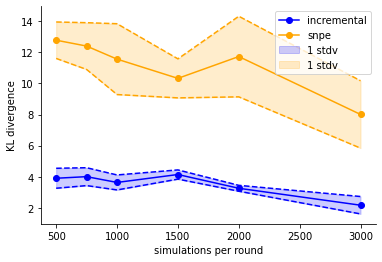

In [40]:


plt.plot(num_simulations_list, mean_incremental, '-o',label='incremental', color='blue')
plt.plot(num_simulations_list, mean_snpe, '-o', label='snpe', color='orange')

plt.plot(num_simulations_list, upper_incremental, '--', color='blue')
plt.plot(num_simulations_list, upper_snpe, '--',  color='orange')

plt.plot(num_simulations_list, lower_incremental, '--',  color='blue')
plt.plot(num_simulations_list, lower_snpe, '--',  color='orange')


plt.fill_between(x= num_simulations_list, y1=lower_incremental, y2=upper_incremental, color='blue', alpha=0.2,  label='1 stdv')
plt.fill_between(x= num_simulations_list, y1=lower_snpe, y2=upper_snpe, color='orange', alpha=0.2, label='1 stdv')


plt.legend()



plt.xlabel('simulations per round')
plt.ylabel('KL divergence')

sns.despine()

